In [ ]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import pickle
import os

from decoding_functions import *
from reading_data_functions import *
from spot_detection_functions import *

In [ ]:
data_path = '/nfs/research1/gerstung/mg617/ISS_data/'

In [ ]:
# Check the saved results and save the csv decoding file
dataset_name = 'Exp_PD9694d2'
dataset_path = data_path + dataset_name + '/'
tifs_path = dataset_path + 'selected_2k_tiles/'
barcodes_01, K, R, C, gene_names, channels_info = read_taglist_and_channel_info_breastdata(dataset_path)

In [4]:
extracted_spots_path = dataset_path + 'decoding/extracted-spots/'
spots = np.load(extracted_spots_path + dataset_name + '_spots_trackpy6.npy')
spots_loc = read_csv(extracted_spots_path + dataset_name + '_spots_trackpy6_locations.csv')

In [5]:
## Compute decoding output
# out = decoding_function(spots, barcodes_01)
## Save decoding output
# # with open(dataset_path + 'decoding/' + dataset_name + '_out.pickle', 'wb') as fp:
# #     pickle.dump(out, fp)

In [6]:
## Load saved decoding results
with open(dataset_path + 'decoding/' + dataset_name + '_out.pickle', 'rb') as fp:
     out = pickle.load(fp)

In [7]:
# Creating a data frame
df_class_names = np.concatenate((gene_names,['infeasible','background','nan']))
barcodes_AGCT = channels_info['barcodes_AGCT']
df_class_codes = np.concatenate((barcodes_AGCT,['NA','0000','NA']))
decoded_spots_df = decoding_output_to_dataframe(out, df_class_names, df_class_codes)
decoded_df = pd.concat([decoded_spots_df, spots_loc], axis=1)  

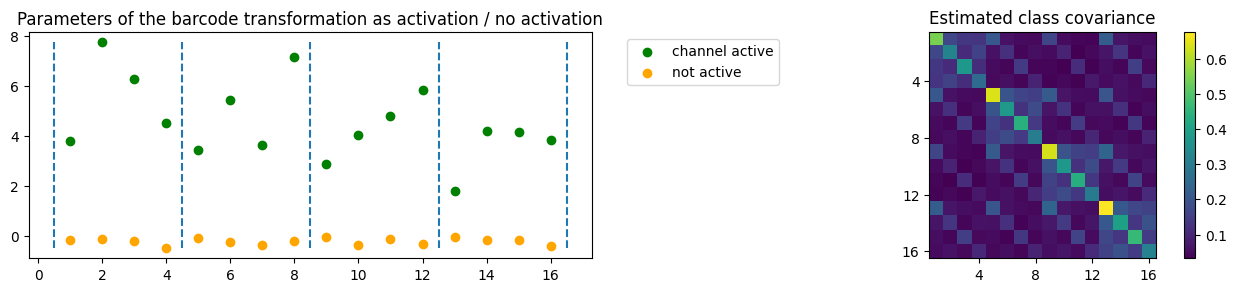

In [8]:
plt.figure(num=None, figsize=(16, 3), dpi=100, facecolor='w', edgecolor='k')
activation = (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star'])[0,:].numpy() #corresponding to the channel activation (code=1)
no_activation = out['params']['codes_tr_consts_v_star'][0,:].numpy() # (code=0)
channel_activation=np.stack((no_activation,activation))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(1,1+R*C),activation,c='green') 
plt.scatter(np.arange(1,1+R*C),no_activation,c='orange') 
plt.legend(('channel active','not active'),bbox_to_anchor=(1.05, 1), loc='upper left')
plt.vlines(np.arange(0.5,R*C+.8,C), out['params']['codes_tr_consts_v_star'].min(), (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star']).max(), linestyles='dashed')
plt.title('Parameters of the barcode transformation as activation / no activation')
plt.subplot(1, 2, 2)
plt.imshow(out['params']['sigma_star'])
plt.yticks(np.arange(3,R*C,4),np.arange(4, R*C+1, 4))
plt.xticks(np.arange(3,R*C,4),np.arange(4, R*C+1, 4))
plt.colorbar()
plt.title('Estimated class covariance')
#plt.savefig(dataset_path+'decoding/' + dataset_name +'_params.png')
plt.show()

The initial loss is 29.398959515230104 and the final loss is 13.988730159719712


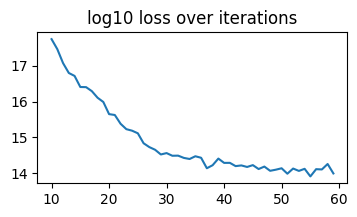

In [9]:
print('The initial loss is {} and the final loss is {}'.format(1/out['class_probs'].shape[0]*out['params']['losses'][0],1/out['class_probs'].shape[0]*out['params']['losses'][len(out['params']['losses'])-1]))
plt.figure(num=None, figsize=(4, 2), dpi=100, facecolor='w', edgecolor='k')
plt.plot(np.arange(10,len(out['params']['losses'])),(1/out['class_probs'].shape[0]*np.asarray(out['params']['losses'][10:])))
plt.title('log10 loss over iterations')
plt.show()

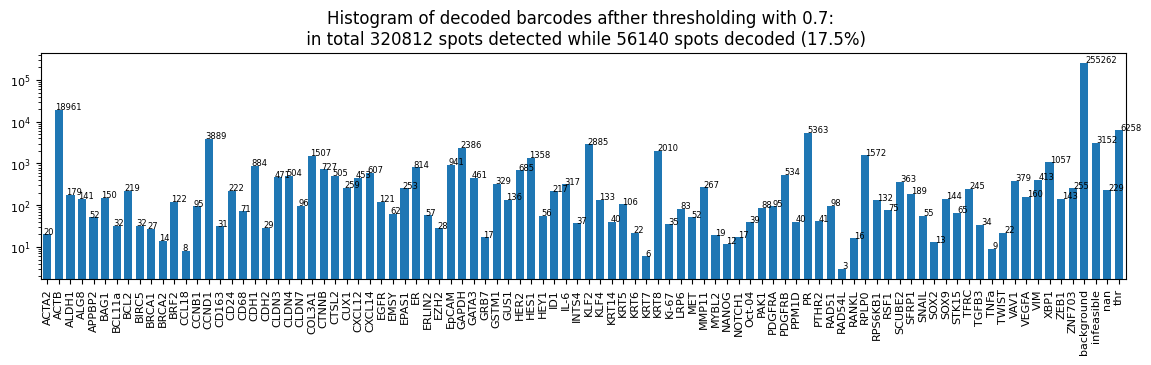

In [10]:
thr=0.7
df = pd.concat([decoded_df.Name[decoded_df.Probability >thr].replace('perforin','Perforin').value_counts(), decoded_df.Name[decoded_df.Probability <=thr].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)
plt.figure(num=None, figsize=(14, 3), dpi=100, facecolor='w', edgecolor='k')
ax = df.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=8)
ax.set_facecolor('w')
num_decoded_barcodes = sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr))
#ax.legend(["gmm: {} decoded spots with prob > {}".format(num_decoded_barcodes,thr)],fontsize=8)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('Histogram of decoded barcodes afther thresholding with {}: \n in total {} spots detected while {} spots decoded ({}%)'.format(thr,decoded_df.shape[0], num_decoded_barcodes , np.round(100*num_decoded_barcodes/ decoded_df.shape[0], 2 )))       
#plt.savefig(dataset_path+'decoding/' + dataset_name +'_hist_gmm.png')
plt.show()

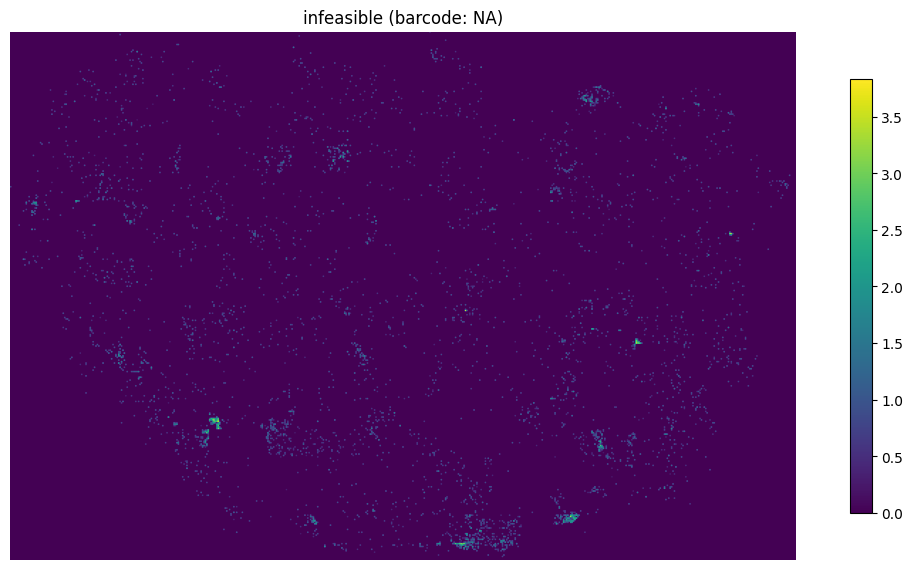

In [11]:
name = 'infeasible'#'background'#
thr = 0.
grid = 100
plot_probs = True
x_coord = np.floor(decoded_df.X[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy(dtype=np.double)/grid).astype(np.int32)
y_coord = np.floor(decoded_df.Y[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy(dtype=np.double)/grid).astype(np.int32)
D_gmm = np.zeros((int(np.ceil(decoded_df.Y.to_numpy(dtype=np.double).max()/grid)),int(np.ceil(decoded_df.X.to_numpy(dtype=np.double).max()/grid))))
if plot_probs:
    prob = decoded_df.Probability[decoded_df.Name == name].to_numpy(dtype=np.double)
    prob[prob<thr]=0
    for i in range(len(x_coord)):
        D_gmm[y_coord[i],x_coord[i]] = D_gmm[y_coord[i],x_coord[i]] + prob[i]
else:
    coords = np.concatenate((y_coord.reshape((len(x_coord),1)),x_coord.reshape((len(x_coord),1))), axis=1)
    coords_u ,coords_c = np.unique(coords ,axis=0, return_counts=True)
    D_gmm[coords_u[:,0],coords_u[:,1]]=coords_c
plt.figure(num=None, figsize=(14, 7), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log2(1+D_gmm))
plt.axis('off')
plt.colorbar(fraction=0.02)
plt.title('{} (barcode: {})'.format(name,df_class_codes[df_class_names==name][0]))
#plt.savefig(dataset_path+'decoding/' + dataset_name +'_'+name+'.png')
plt.show()

In [12]:
#Load Nilsson's decoding
orig_df = read_csv(dataset_path + dataset_name.replace('_Top','').replace('_Bottom','') + '_Nilsson_decoding_result/' + dataset_name.replace('_Top','').replace('_Bottom','') + '_Nilsson_decoding.csv')

In [13]:
#np.unique(orig_df.Gene)

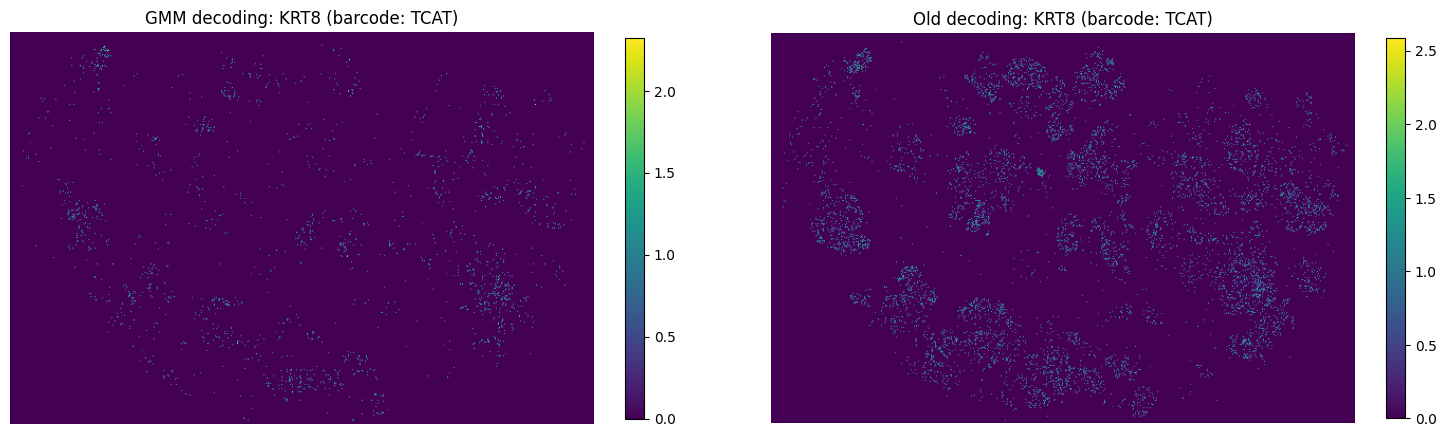

In [16]:
name = 'KRT8'#'ACTB'#'AP3B22mut'
thr = 0.7
grid = 100
x_coord = np.floor(decoded_df.X[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy(dtype=np.double)/grid).astype(np.int32)
y_coord = np.floor(decoded_df.Y[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy(dtype=np.double)/grid).astype(np.int32)
N_g = len(x_coord)
D_gmm = np.zeros((int(np.ceil(decoded_df.Y.to_numpy(dtype=np.double).max()/grid)),int(np.ceil(decoded_df.X.to_numpy(dtype=np.double).max()/grid))))
coords = np.concatenate((y_coord.reshape((N_g,1)),x_coord.reshape((N_g,1))), axis=1)
coords_u ,coords_c = np.unique(coords ,axis=0, return_counts=True)
D_gmm[coords_u[:,0],coords_u[:,1]]=coords_c
## Nilsson's decoding

if dataset_name[0:3] == 'Mut':
    x_coord = np.floor(orig_df.PosX[orig_df.Gene.replace('-','') == name.replace('_','').replace('infeasible','NNNN')].to_numpy(dtype=np.double)/grid).astype(np.int32)
    y_coord = np.floor(orig_df.PosY[orig_df.Gene.replace('-','') == name.replace('_','').replace('infeasible','NNNN')].to_numpy(dtype=np.double)/grid).astype(np.int32)
    y=orig_df.PosY.to_numpy(dtype=np.double);y=y[~np.isnan(y)]
    x=orig_df.PosX.to_numpy(dtype=np.double);x=x[~np.isnan(x)]

if dataset_name[0:3] == 'Exp':
    x_coord = np.floor(orig_df.global_X_pos[orig_df.name == name].to_numpy(dtype=np.double)/grid).astype(np.int32)
    y_coord = np.floor(orig_df.global_Y_pos[orig_df.name == name].to_numpy(dtype=np.double)/grid).astype(np.int32)
    y=orig_df.global_Y_pos.to_numpy(dtype=np.double);y=y[~np.isnan(y)]
    x=orig_df.global_X_pos.to_numpy(dtype=np.double);x=x[~np.isnan(x)]

D_orig= np.zeros((int(np.ceil(y.max()/grid)),int(np.ceil(x.max()/grid))))
N_g = len(x_coord)
coords = np.concatenate((y_coord.reshape((N_g,1)),x_coord.reshape((N_g,1))), axis=1)
coords[coords<0]=0
coords_u ,coords_c = np.unique(coords ,axis=0, return_counts=True)
D_orig[coords_u[:,0],coords_u[:,1]]=coords_c
plt.figure(num=None, figsize=(18, 7), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.imshow(np.log2(1+D_gmm))
plt.axis('off')
plt.colorbar(fraction=0.03)
plt.title('GMM decoding: {} (barcode: {})'.format(name,df_class_codes[df_class_names==name][0]))
plt.subplot(1, 2, 2)
plt.imshow(np.log2(1+D_orig))
plt.axis('off')
plt.colorbar(fraction=0.03)
plt.title('Old decoding: {} (barcode: {})'.format(name,df_class_codes[df_class_names==name][0]))
#plt.savefig(dataset_path+'decoding/' + dataset_name +'_'+name+'.png')
plt.show()

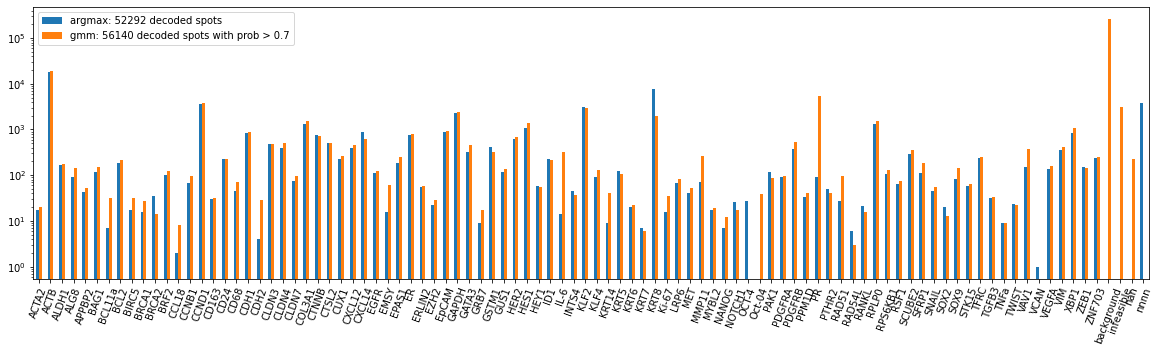

In [15]:
thr=0.7
if dataset_name[0:3] == 'Exp':
    df = pd.concat([orig_df.name.replace('NNNN','nnnn').replace('perforin','Perforin').replace('_','').replace('-','').value_counts(),
                    decoded_df.Name[decoded_df.Probability >thr].replace('_','').replace('-','').replace('perforin','Perforin').value_counts()], axis=1).sort_index(axis=0)
if dataset_name[0:3] == 'Mut':
    df = pd.concat([orig_df.Gene.replace('NNNN','nnnn').replace('_','').replace('-','').replace('perforin','Perforin').value_counts(),
                    decoded_df.Name[decoded_df.Probability >thr].replace('_','').replace('-','').replace('perforin','Perforin').value_counts()], axis=1).sort_index(axis=0)
ax = df.plot(kind='bar',width=0.5,rot=70,logy=True,figsize=(20,5))
ax.set_facecolor('w')
if dataset_name[0:3] == 'Mut':
    ax.legend(["argmax: {} decoded spots".format(sum(orig_df.Gene!='NNNN')), "gmm: {} decoded spots with prob > {}".format(sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr)),thr)])        
if dataset_name[0:3] == 'Exp':
    ax.legend(["argmax: {} decoded spots".format(sum(orig_df.name!='NNNN')), "gmm: {} decoded spots with prob > {}".format(sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr)),thr)])        
#plt.savefig(dataset_path+'decoding/' + dataset_name +'_hist_compare-trackpy6.png')
plt.show()

In [30]:
#Save dataframe with decoded spots in the designated folder
decoded_df.to_csv(dataset_path + 'decoding/' + dataset_name + '_GMMdecoding-trackpy6.csv', index=False)